# Data dictionary

- bathroom - bathroomcnt
- bedroom - bedroomcnt 
- square_feet - calculatedfinishedsquarefeet: there are multiple columns related to square footage; I chose this one because all of the others had much more NULL data, and did not include anything new
- tax - taxamount: we use taxamount to later calculate tax rates per county
- fips - (Federal Information Processing Standards): we included the fips column because that's what we use to find the county.
- house_value - taxvaluedollarcnt: we use taxvaluedollarcnt as property value because it includes land and structure

In [47]:
import pandas as pd
import numpy as np
from env import get_db_url
import evaluate, split_scale
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import SelectKBest, f_regression, RFE
from sklearn.metrics import mean_squared_error as mse
from sklearn.preprocessing import PolynomialFeatures
from statsmodels.formula.api import ols
from math import sqrt

# Data acquisition

In [48]:
url = get_db_url('zillow')
query = ('''
SELECT bathroomcnt AS bathroom, bedroomcnt AS bedroom, 
    calculatedfinishedsquarefeet AS square_feet, taxamount AS tax, 
    fips, taxvaluedollarcnt AS house_value 
FROM properties_2017
JOIN predictions_2017 USING (parcelid)
WHERE propertylandusetypeid = 261
    AND (transactiondate >= '2017-05-01' AND 
         transactiondate <= '2017-06-31')
''')
df_orig = pd.read_sql(query, url)

In [49]:
counties = pd.read_table('FIPS.txt', header=1)
counties.columns = ['FIPS', 'county', 'state']
counties.head()

,FIPS,county,state
0,1001,Autauga,AL
1,1003,Baldwin,AL
2,1005,Barbour,AL
3,1007,Bibb,AL
4,1009,Blount,AL


# Data Preparation

In [50]:
df = df_orig.copy()
df.head(10)

,bathroom,bedroom,square_feet,tax,fips,house_value
0,2.000,3.000,1458.000,2319.900,6037.000,136104.000
1,1.000,2.000,1421.000,543.690,6037.000,35606.000
2,3.000,4.000,2541.000,9819.720,6059.000,880456.000
3,2.000,3.000,1650.000,7673.190,6037.000,614000.000
4,1.000,2.000,693.000,3267.470,6037.000,274237.000
5,0.000,0.000,1378.000,2135.390,6037.000,168828.000
6,2.000,3.000,1668.000,2376.340,6059.000,196483.000
7,2.500,3.000,1653.000,6185.280,6059.000,605000.000
8,1.000,3.000,879.000,2015.780,6059.000,141875.000
9,2.000,3.000,1108.000,5990.500,6037.000,486866.000


In [51]:
df = pd.merge(df, counties, left_on='fips', 
                 right_on='FIPS', how='left')
df.drop(columns='fips', inplace=True)
df.head()

,bathroom,bedroom,square_feet,tax,house_value,FIPS,county,state
0,2.000,3.000,1458.000,2319.900,136104.000,6037,Los Angeles,CA
1,1.000,2.000,1421.000,543.690,35606.000,6037,Los Angeles,CA
2,3.000,4.000,2541.000,9819.720,880456.000,6059,Orange,CA
3,2.000,3.000,1650.000,7673.190,614000.000,6037,Los Angeles,CA
4,1.000,2.000,693.000,3267.470,274237.000,6037,Los Angeles,CA


In [52]:
df.isnull().sum()

bathroom        0
bedroom         0
square_feet    24
tax             1
house_value     0
FIPS            0
county          0
state           0
dtype: int64

In [53]:
df.shape[0]

15036

In [54]:
bathroom_std = df.bathroom.std()
bedroom_std = df.bedroom.std()
square_feet_std = df.square_feet.std()
house_value_std = df.house_value.std()

df.bedroom = df.bedroom[(df.bedroom <= bedroom_std * 10) &
                       (df.bedroom != 0)]
df.bathroom = df.bathroom[(df.bathroom <= bathroom_std * 10) &
                        (df.bathroom != 0) ]
df.square_feet = df.square_feet[
    (df.square_feet <= square_feet_std * 10) &
    (df.square_feet >= square_feet_std * .1)]
df.house_value = df.house_value[
    (df.house_value <= house_value_std * 10) & 
    (df.house_value >= house_value_std * .1)]

This data contains many points which I consider wild outliers. I chose to remove all data points that were above or below 10 standard deviations of each variable. I also removed the data points where bedroom or bathroom were listed as 0.

In [57]:
df.isnull().sum()

bathroom         41
bedroom          47
square_feet      31
tax               1
house_value    1158
FIPS              0
county            0
state             0
dtype: int64

This is how many data points I found to be extreme outliers, and so removed

In [58]:
df.dropna(inplace=True)
df.shape[0]

13829

In [59]:
df.square_feet = df.square_feet.astype(int)
df.bedroom = df.bedroom.astype(int)
df.house_value = df.house_value.astype(int)

In [60]:
df.head()

,bathroom,bedroom,square_feet,tax,house_value,FIPS,county,state
0,2.000,3,1458,2319.900,136104,6037,Los Angeles,CA
2,3.000,4,2541,9819.720,880456,6059,Orange,CA
3,2.000,3,1650,7673.190,614000,6037,Los Angeles,CA
4,1.000,2,693,3267.470,274237,6037,Los Angeles,CA
6,2.000,3,1668,2376.340,196483,6059,Orange,CA


# Data exploration

In [61]:
train, test = split_scale.split_my_data(df, .8)
train.head()

,bathroom,bedroom,square_feet,tax,house_value,FIPS,county,state
6811,4.000,4,1919,3725.420,344457,6111,Ventura,CA
11370,2.000,3,1564,9880.170,875355,6037,Los Angeles,CA
6923,3.500,4,2384,4577.560,457510,6059,Orange,CA
11760,2.000,4,1681,2521.440,172366,6037,Los Angeles,CA
836,2.000,3,1262,5929.440,488153,6037,Los Angeles,CA


## Null Hypothesis:
##### There is no correlation between bathroom count being low (less than 3) and house value

In [62]:
x = train[(train.bathroom < 3)].house_value
mu = train.house_value.mean()
t_stat, p = stats.ttest_1samp(x, mu)
t_stat, p

(-41.74458201730139, 0.0)

This t statistic being so far from 0 means we should reject our null hypothesis

In [63]:
r, p = stats.pearsonr(train.bathroom, train.house_value)
r, p

(0.5257587327603573, 0.0)

This high r value indicates a high correlation between bathroom count and house value

In [64]:
r, p = stats.pearsonr(train.bedroom, train.house_value)
r, p

(0.25785555750000805, 1.6308425836055954e-167)

This relatively small r value indicates that there is a low correlation between bedroom count and house value

In [65]:
r, p = stats.pearsonr(train.square_feet, train.house_value)
r, p

(0.5967854149657603, 0.0)

This high r value indicates a very high correlation between square footage and house value

In [66]:
train.head()

,bathroom,bedroom,square_feet,tax,house_value,FIPS,county,state
6811,4.000,4,1919,3725.420,344457,6111,Ventura,CA
11370,2.000,3,1564,9880.170,875355,6037,Los Angeles,CA
6923,3.500,4,2384,4577.560,457510,6059,Orange,CA
11760,2.000,4,1681,2521.440,172366,6037,Los Angeles,CA
836,2.000,3,1262,5929.440,488153,6037,Los Angeles,CA


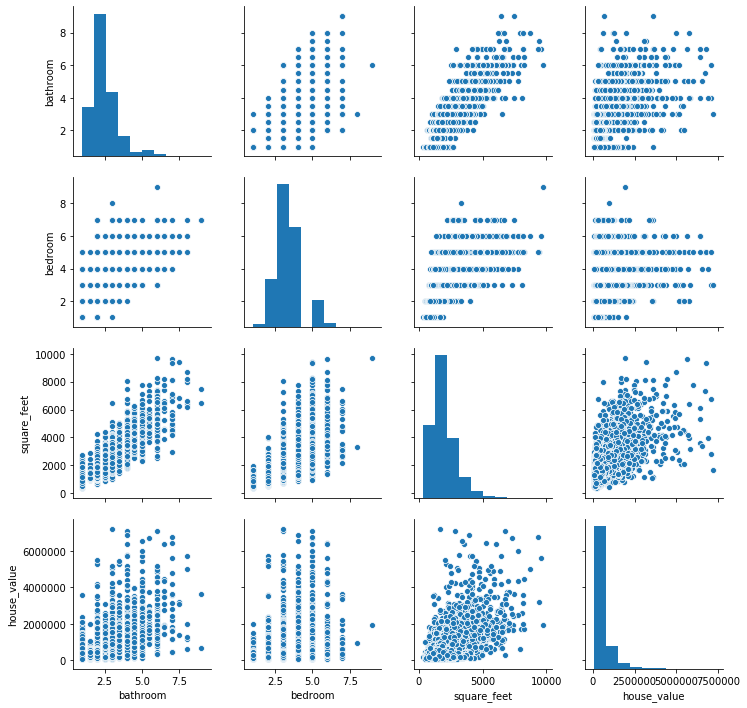

In [67]:
train2 = train.copy()
train2.drop(columns=['county', 'tax', 'state', 'FIPS'], inplace=True)
sns.pairplot(train2)

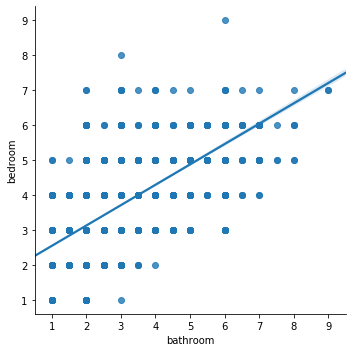

In [68]:
sns.lmplot('bathroom', 'bedroom', train)

This graph implies a likely correlation between bedroom and bathroom, so it would be best to not use both in predicting house value. Bathroom is shown to have a much better correlation with the independent variable as shown in the pairplot above, so I will be using a model that does not use bedroom.

In [69]:
train.head()

,bathroom,bedroom,square_feet,tax,house_value,FIPS,county,state
6811,4.000,4,1919,3725.420,344457,6111,Ventura,CA
11370,2.000,3,1564,9880.170,875355,6037,Los Angeles,CA
6923,3.500,4,2384,4577.560,457510,6059,Orange,CA
11760,2.000,4,1681,2521.440,172366,6037,Los Angeles,CA
836,2.000,3,1262,5929.440,488153,6037,Los Angeles,CA


# Feature engineering and Modeling

In [70]:
X_train = train[['bathroom', 'bedroom', 'square_feet']]
y_train = train.house_value

In [71]:
selector = SelectKBest(f_regression, k=2)
selector.fit(X_train, y_train)
X2 = selector.transform(X_train)

support = selector.get_support()
X_train.columns[support].tolist()

['bathroom', 'square_feet']

In [72]:
rfe = RFE(LinearRegression(), 2)
X_rfe = rfe.fit_transform(X_train, y_train)
mask = rfe.support_
X_train.columns[mask].tolist()

['bathroom', 'bedroom']

In [73]:
predictions = pd.DataFrame({'actual': train.house_value})
predictions.head()

,actual
6811,344457
11370,875355
6923,457510
11760,172366
836,488153


In [74]:
predictions['base_average'] = train.house_value.mean()
predictions.base_average = predictions.base_average.astype(int)
predictions.head()

,actual,base_average
6811,344457,565626
11370,875355,565626
6923,457510,565626
11760,172366,565626
836,488153,565626


In [75]:
#Using all 3 features
simple_lm_all = LinearRegression()
simple_lm_all.fit(X_train, y_train)
predictions['simple_lm_all'] = simple_lm_all.predict(X_train)
predictions.simple_lm_all = predictions.simple_lm_all.astype(int)
predictions.head()

,actual,base_average,simple_lm_all
6811,344457,565626,574242
11370,875355,565626,425546
6923,457510,565626,708995
11760,172366,565626,329764
836,488153,565626,312766


In [76]:
# Using the two features suggested by SelectKBest
X = train[['bathroom', 'square_feet']]

simple_lm_k2 = LinearRegression()
simple_lm_k2.fit(X, y_train)
predictions['simple_lm_k2'] = simple_lm_k2.predict(X)
predictions.simple_lm_k2 = predictions.simple_lm_k2.astype(int)
predictions.head()

,actual,base_average,simple_lm_all,simple_lm_k2
6811,344457,565626,574242,594237
11370,875355,565626,425546,412439
6923,457510,565626,708995,731775
11760,172366,565626,329764,451102
836,488153,565626,312766,312642


In [77]:
lm_rfe = LinearRegression()
rfe_use = RFE(lm_rfe, 2)
rfe_use.fit(X_train, y_train)
X_rfe = rfe_use.transform(X_train)
lm_rfe.fit(X_rfe, y_train)

predictions['rfe'] = lm_rfe.predict(X_rfe)
predictions.rfe = predictions.rfe.astype(int)
predictions.head()

,actual,base_average,simple_lm_all,simple_lm_k2,rfe
6811,344457,565626,574242,594237,1086368
11370,875355,565626,425546,412439,457705
6923,457510,565626,708995,731775,908797
11760,172366,565626,329764,451102,376087
836,488153,565626,312766,312642,457705


In [78]:
poly = PolynomialFeatures(degree=3, interaction_only=True, 
                              include_bias=False)
poly.fit(X_train)
X_poly = pd.DataFrame(poly.transform(X_train), 
                    columns=poly.get_feature_names(X_train.columns))

lm = LinearRegression()
rfe = RFE(lm, 4)
rfe.fit(X_poly, y_train)
X_rfe = pd.DataFrame(rfe.transform(X_poly), 
                         columns=X_poly.columns[rfe.support_])
X_rfe

,bathroom,bedroom,square_feet,bathroom bedroom
0,4.000,4.000,1919.000,16.000
1,2.000,3.000,1564.000,6.000
2,3.500,4.000,2384.000,14.000
3,2.000,4.000,1681.000,8.000
4,2.000,3.000,1262.000,6.000
...,...,...,...,...
11058,3.000,3.000,2178.000,9.000
11059,3.500,4.000,3894.000,14.000
11060,1.000,2.000,907.000,2.000
11061,1.000,4.000,1279.000,4.000


In [79]:
lm_poly = LinearRegression().fit(X_rfe, y_train)
predictions['poly'] = lm_poly.predict(X_rfe)
predictions.poly = predictions.poly.astype(int)
predictions.head()

,actual,base_average,simple_lm_all,simple_lm_k2,rfe,poly
6811,344457,565626,574242,594237,1086368,583110
11370,875355,565626,425546,412439,457705,418000
6923,457510,565626,708995,731775,908797,703526
11760,172366,565626,329764,451102,376087,312696
836,488153,565626,312766,312642,457705,309741


In [80]:
evaluate.better_than_baseline(y_train, predictions.simple_lm_k2)

True: 124038199260.89 is greater than 0


In [81]:
pd.options.display.float_format = '{:.3f}'.format
predictions.apply(lambda c: sqrt(mse(predictions.actual, c)))

actual               0.000
base_average    589475.846
simple_lm_all   462598.476
simple_lm_k2    472698.185
rfe             498029.197
poly            461011.853
dtype: float64

With an RMSE of 589,475 on the baseline model, it is clear that all 4 other models do better because their RMSEs are lower, with polynomial having the lowest. However, we will be using the lm_kbest model because it is the next lowest that does not use bedroom as a feature, which I have previously shown to be not useful.

# Final model and Evaluation

In [82]:
X_test = test[['bathroom', 'bedroom', 'square_feet']]
y_test = test.house_value
X_test.head()

,bathroom,bedroom,square_feet
9298,2.000,3,1189
9294,3.000,3,3231
7766,3.000,5,1803
7685,2.500,4,1889
1188,3.000,3,1292


In [83]:
X_test_poly = poly.transform(X_test)
X_test_rfe = rfe.transform(X_test_poly)
y_test_predictions_poly = lm_poly.predict(X_test_rfe)

poly_rmse = sqrt(mse(y_test, y_test_predictions_poly))
poly_rmse

431537.0511389831

In [126]:
X = X_test.drop(columns='bedroom')
y_test_predictions_k2 = simple_lm_k2.predict(X)

k2_rmse = sqrt(mse(y_test, y_test_predictions_k2))
k2_rmse

443841.8165769579

In [128]:
pd.DataFrame(y_test_predictions_k2)

,0
0,288519.985
1,995546.722
2,523661.446
3,535958.302
4,354800.539
...,...
2761,512496.219
2762,862705.069
2763,1091047.314
2764,577995.827


In [153]:
model = ols('y_test ~ X', data=test).fit()
r2, p = evaluate.model_significance(model)
r2, p

(0.3749994913012453, 1.0203103529411329e-282)

R2 shows the percent of variance explained by our data. This being .375 shows that almost forty percent of our variance is explained by our independent variables, which shows that these are decent indicators for predicting house value, but there might be other factors we haven't taken into account.

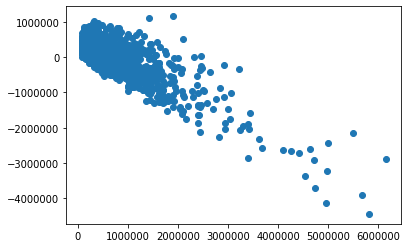

In [86]:
evaluate.plot_residuals(y_test, y_test_predictions_poly)

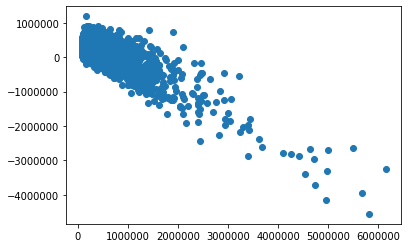

In [87]:
evaluate.plot_residuals(y_test, y_test_predictions_k2)

- Using the model that had the lowest RMSE not using bedrooms, simple_lm_k2, I predicted the test values, and got an RMSE that is even slightly better sitting at 443k. 
- Using an ols model my test data resulted in an r2 statistic of .397, showing that a sizeable portion of the variance can be explained by the data.
- Finally, a plot of the residuals shows that because there is a discernable pattern, there is likely more to this data that might be extracted at a later time, or perhaps it would be better to use a nonlinear model to predict this data.
- With all of these factors taken into account, I can comfortably call this a useable model for delivery, with opportunity for growth.

# Tax distributions

In [88]:
df.head()

,bathroom,bedroom,square_feet,tax,house_value,FIPS,county,state
0,2.000,3,1458,2319.900,136104,6037,Los Angeles,CA
2,3.000,4,2541,9819.720,880456,6059,Orange,CA
3,2.000,3,1650,7673.190,614000,6037,Los Angeles,CA
4,1.000,2,693,3267.470,274237,6037,Los Angeles,CA
6,2.000,3,1668,2376.340,196483,6059,Orange,CA


In [89]:
df['tax_rate'] = df.tax / df.house_value
df.groupby('county').tax_rate.mean()

county
Los Angeles   0.014
Orange        0.012
Ventura       0.012
Name: tax_rate, dtype: float64

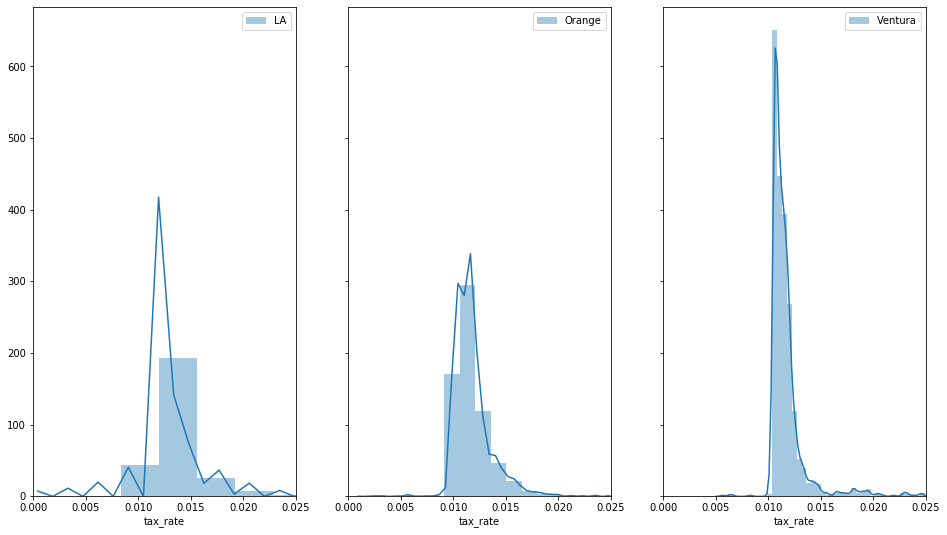

In [152]:
f, axes = plt.subplots(1, 3, sharey=True, sharex=True, figsize=(16,9))
sns.distplot(df.tax_rate[df.county == 'Los Angeles'], 
             label='LA', ax=axes[0])
sns.distplot(df.tax_rate[df.county == 'Orange'], 
             label='Orange', ax=axes[1])
sns.distplot(df.tax_rate[df.county == 'Ventura'], 
             label='Ventura', ax=axes[2])
plt.xlim(0,0.025)
axes[0].legend(), axes[1].legend(), axes[2].legend()
plt.show()